# Irregular To Regular In R

When using tick data, its timestamps $t_i$ are irregular.  We often want values from our time series as of a _different_ set of timestamps $\tau_i$, and we want the computation to be vectorized for speed.  Sometimes the  $\tau_i$ are regular timestamps, for example when we want to calculate a Sharpe ratio or worst hour or something.  Sometimes the $\tau_i$  are irregular, for example when we need future (or past price references)

The trick to making this work is to take your tick data, and form a new "joined" table with rows inserted for all the timestamps you want.  Forward fill it, and then query the big joined table for teh timestamps you need.

Another trick we display here is figuring out values from a _different_ tick data table that it had as of the relevant observation times ("reference times") in the original tick data table.

In [14]:
library(data.table)
library(scales)
library(ggplot2)

### Setup

Here we (parametrically) define two irregular tick data tables (one with "price" and the other with "volatility")

In [2]:
irreg_count = 16
reg_dt = 90
reg_offset = 5

In [3]:
# Set up random time and price observations
set.seed(42)
ts = unique(c(reg_offset + 2*reg_dt,as.integer(1000*runif(irreg_count))))
ps = 20+as.integer(1000*runif(length(ts)))/100
ts = ts[order(ts)]
irreg = data.table(time=ts, price=ps)

# Make different irregular table with some datum we care about, here we call it volatility but it could be a mid price
ots = unique(as.integer(1000*runif(2*length(ts))))
vs = 10 + as.integer(1000*runif(length(ots)))/200
ots = ots[order(ots)]
other_irreg = data.table(time=ots, vola=vs)

# Convenient to have a reference time column equal to our time index, for lookups
irreg$reference_time = irreg$time
other_irreg$reference_time = other_irreg$time

irreg

time,price,reference_time
<dbl>,<dbl>,<dbl>
134,29.78,134
185,21.17,185
255,24.74,255
286,25.60,286
457,29.04,457
462,21.38,462
519,29.88,519
641,29.46,641
656,20.82,656


In [4]:
other_irreg

time,vola,reference_time
<int>,<dbl>,<int>
3,14.140,3
7,13.465,7
37,11.200,37
38,10.210,38
171,10.700,171
189,11.080,189
207,12.395,207
261,10.985,261
271,13.595,271


In [5]:
# Define the timestamps we want forward-fill values for (they are called "regular" here, but actually do not need to be regular)
reg_ts = reg_offset + scales::fullseq(range(ts), reg_dt)
reg_ts

[1]  95 185 275 365 455 545 635 725 815 905 995

### Figure out the most recent values of price for our regular timestamps

Here we show how to do the joined table trick in long form

In [6]:
joined_ts = unique(c(reg_ts, irreg$time))
joined_ts = joined_ts[order(joined_ts)]  # Note it is important to SORT joined indexes so forward fill works properly, pd.Index.union() does that by default

joined_ts

[1]  95 134 185 255 275 286 365 455 457 462 519 545 635 641 656 705 719 725 736
[20] 815 830 905 914 934 937 940 995

In [7]:
# Make a data.table defining all times together
jts = irreg[, .(time = joined_ts)]

# Construct a "big" table with slots for all columns at all timestamps
joined_with_NA = irreg[jts, on='time']
                                      
# Tell the joined table to use most recently observed value (the Python equivalent is df.fillna(method='ffill'))
setnafill(joined_with_NA, type = "locf")

joined_with_NA

time,price,reference_time
<dbl>,<dbl>,<dbl>
95,NA,NA
134,29.78,134
185,21.17,185
255,24.74,255
275,24.74,255
286,25.60,286
365,25.60,286
455,25.60,286
457,29.04,457


In [8]:
# Sample the "big" table at the timestamps we really want
wanted = joined_with_NA[,.(time=reg_ts)]
regular_values = joined_with_NA[wanted, on=.(time)]
regular_values

time,price,reference_time
<dbl>,<dbl>,<dbl>
95,NA,NA
185,21.17,185
275,24.74,255
365,25.60,286
455,25.60,286
545,29.88,519
635,29.88,519
725,23.90,719
815,29.05,736


### What were the _volatilities_ as of the reference times in this data frame?

We use a similar trick as above.  For convenience let's definie everything in a function

##### Function For Inferring Values

In [9]:
infer_values = function(wanted_timestamps, data_df, time_colm='time') {
    # Ensure we have a time column
    stopifnot(time_colm %in% names(data_df))
    
    # Same as above, just a little generalized
    joined_ts = unique(c(wanted_timestamps, data_df[,get(time_colm)]))
    joined_ts = joined_ts[order(joined_ts)]
    
    # Using eval(parse(...)) here is working but hacky
    join_expr = paste('.(', time_colm,' = joined_ts)', sep='')
    jts = data_df[, eval(parse(text=join_expr))]  
    
    joined_with_NA = data_df[jts, on=time_colm]
    setnafill(joined_with_NA, type = "locf")
    want_expr = paste('.(', time_colm,' = wanted_timestamps)', sep='')
    wanted = joined_with_NA[,eval(parse(text=want_expr))]
    wanted_values = joined_with_NA[wanted, on=time_colm]
    wanted_values
}

##### Using The Function To Get Values At The Regular Times

In [10]:
vola_at_reg_ts = infer_values(reg_ts, other_irreg)[,vola]
vola_at_reg_ts

[1] 10.210 10.700 13.595 11.875 10.785 11.795 12.815 11.525 11.040 13.670
[11] 13.130

##### Using The Function To Get Values At Reference Times

In [11]:
vola_at_reference_ts = infer_values(regular_values[,reference_time], other_irreg)[,vola]
vola_at_reference_ts

[1]     NA 10.700 12.395 13.595 13.595 11.795 11.795 11.525 11.525 11.040
[11] 11.665

### Putting all the data together

In [12]:
regular_values[, current_vola:=vola_at_reg_ts]
regular_values[, reference_vola:=vola_at_reference_ts]
setnames(regular_values, 'reference_time', 'price_ref_time', skip_absent=T)

regular_values

time,price,price_ref_time,current_vola,reference_vola
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
95,NA,NA,10.210,NA
185,21.17,185,10.700,10.700
275,24.74,255,13.595,12.395
365,25.60,286,11.875,13.595
455,25.60,286,10.785,13.595
545,29.88,519,11.795,11.795
635,29.88,519,12.815,11.795
725,23.90,719,11.525,11.525
815,29.05,736,11.040,11.525


### Plot

Warning message:
“Removed 1 rows containing missing values (`geom_vline()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


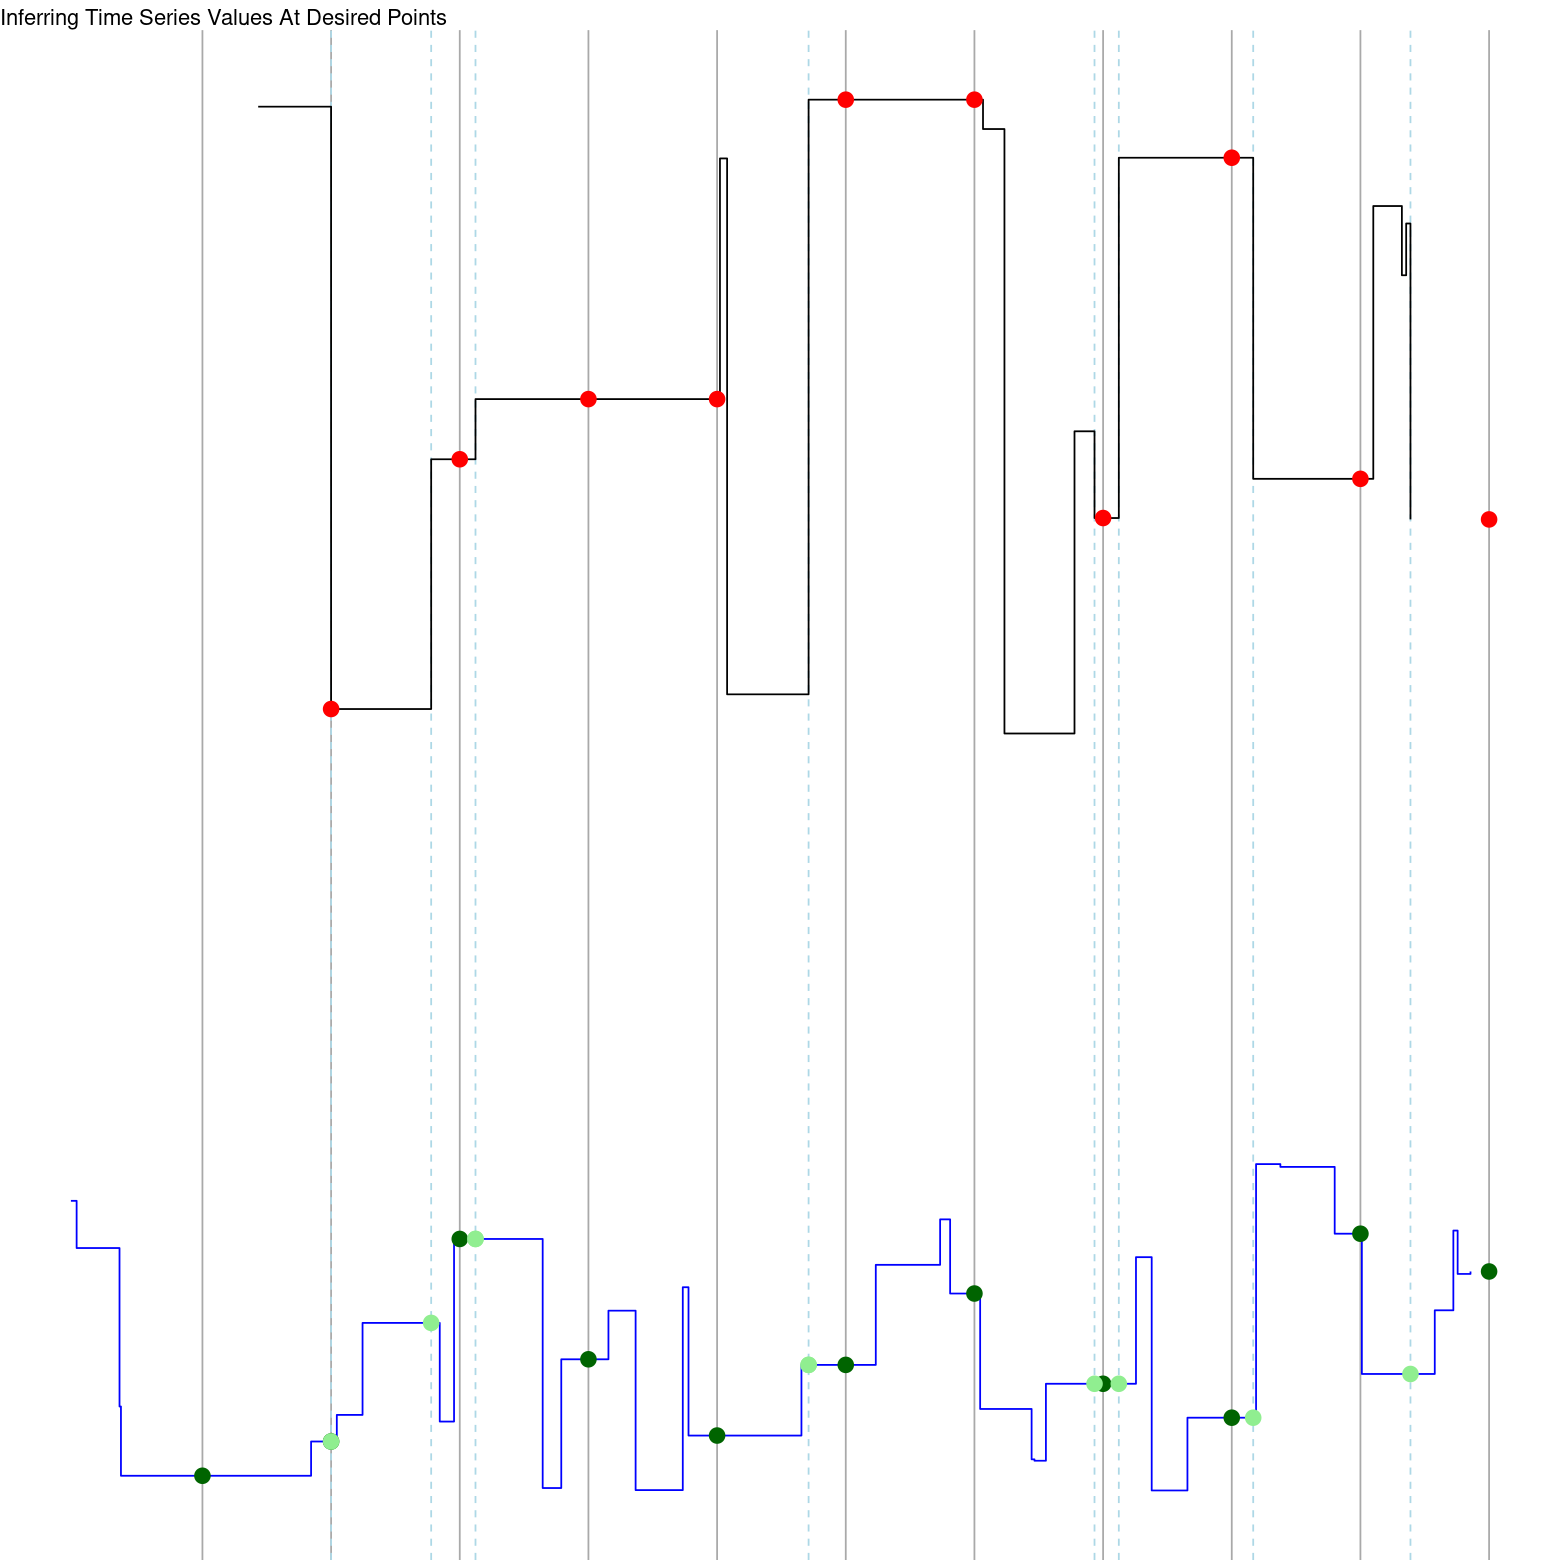

In [42]:
options(repr.plot.width =13, repr.plot.height =13) 
(
    ggplot(irreg,aes(x=time,y=price)) 
    + geom_vline(data=regular_values, mapping=aes(xintercept=time), color='darkgray') 
    + geom_vline(data=regular_values, mapping=aes(xintercept=price_ref_time), color='lightblue', linetype="dashed") 
    + geom_step() 
    + geom_point(data=regular_values, color='red', size=4) 
    + geom_step(data=other_irreg, mapping=aes(x=time,y=vola), color='blue')
    + geom_point(data=regular_values, mapping=aes(x=time,y=current_vola), color='darkgreen', size=4) 
    + geom_point(data=regular_values, mapping=aes(x=price_ref_time,y=reference_vola), color='lightgreen', size=4) 
    + labs(title="Inferring Time Series Values At Desired Points")
    + theme_void()
)
